# Rakuten USA - Data Engineering Test

### Goal
The goal of this test is not ment to be exhaustive, but we do want to test your skills in analytical thinking, SQL, data wrangling, data analysis, and data visualization. 

**Please remember:** The better that you do on this assignment, the less questions we will have during your on-site interviews. :)

### Expectations
You can expect this test to use the following technologies:
- Python3
- Jupyter Notebook
- PySpark
- PySpark SQL

This test will cover the following areas: 
- Data Cleaning/Wrangling
- Exploratory Data Analysis (EDA)
- Data Visualization

This test should take you no more than 2-4 hours.

### What to turn in, and where to send your test
Please email stirling.waite@rakuten with your finished notebook
- rakuten_engineer_test.ipynb
 
### Questions?
Feel free to email me or call me with any questions about this test
- Email: stirling.waite@rakuten.com
- Phone: 801-856-1426
- LinkedIn Chat: https://www.linkedin.com/in/stirlingwaite/
- Gchat: stirlingw@gmail.com

# About The Dataset

Below you will find a modified free Kaggle competition dataset from https://www.kaggle.com/mayank811/employee-reviews/data using scraped data from Glassdoor.com.

## Context
- Over 67k employee reviews for Google, Amazon, Facebook, Apple, Microsoft, and Netflix.
- Web scraped from Glassdoor

## Content
This dataset contains employee reviews separated into the following categories:

- **Index:** index
- **Company:** Company name
- **Location:** This dataset is global, as such it may include the country's name in parenthesis [i.e "Toronto, ON(Canada)"]. However, if the location is in the USA then it will only include the city and state[i.e "Los Angeles, CA" ]
- **Date Posted:** in the following format MM DD, YYYY
- **Job-Title:** This string will also include whether the reviewer is a 'Current' or 'Former' Employee at the time of the review
- **Summary:** Short summary of employee review
- **Pros:** Pros
- **Cons:** Cons
- **Overall Rating:** 1-5
- **Work/Life Balance Rating:** 1-5
- **Culture and Values Rating:** 1-5
- **Career Opportunities Rating:** 1-5
- **Comp & Benefits Rating:** 1-5
- **Senior Management Rating:** 1-5
- **Helpful Review Count:** 1-5

**Link to Review:** This will provide you with a direct link to the page that contains the review. However it is likely that this link will be outdated

**NOTE:** 'none' is placed in all cells where no data value was found.



In [6]:
import os 


In [7]:
os.getcwd()

'C:\\Users\\Sushil\\Downloads'

# PySpark Initialization

In [110]:
import re
import pyspark
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
from pyspark.sql import functions as fn
from pyspark.sql import types as t
from pyspark.sql.types import *
from datetime import datetime
from pyspark.sql.functions import lit

In [113]:
conf = SparkConf()\
                .setMaster("local[*]")\
                .setAppName("rakutenHomework")
        
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName("spark play").getOrCreate()

In [112]:
spark.stop()

## Read Dataset into Spark

In [114]:
reviews_df = spark.read.csv("employee_reviews_usa.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")
print(reviews_df.count())
reviews_df.show()

28357
+---+-------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+
|_c0|company|         location|        dates|           job_title|             summary|                pros|                cons|      advice_to_mgmt|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|                link|
+---+-------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+
|  0| google|Mountain View, CA|  Feb 8, 2015|Current Employee

# Data Cleaning & Removing Un-Needed Columns

No one likes dirty data.  Let's clean up this dataset to make it more usable for our use case.

 
1. Make the date field more data friendly
    - Hint #1: Use the provided `review_date_udf` udf provided (it will make your life more simple) 
2. Using the "location" column 
    - Add new columns for city, state, country columns
        - Hint #1: Concider using `fn.split()` to split `location` for columns `city` `state` 
        - Hint #2: I've narrowed down the country to just US, so please use something like below to create the `country` column
            - ```lit("US").alias("country")```
3. Using the "job-title" column  
    - Add a new boolean column titled "current_employee" that will show:
        - 1,  if reviewer is a current employee
        - 0,  if reviewer is not a current employee
        - Hint:  Use spark function `fn.when()` and `col("job-title").contains("")`
    - Remove "Former Employee - " and "" from the "job-title" column
        - Hint: Use the udf function `reg_job_title_udf`
4. Drop un-needed columns 
    - "_c0", "link", "pros", "cons", "advice-to-mgmt", "summary", "location"

##### Useful UDF functions needed for below

In [115]:
review_date_udf = fn.udf(
    lambda x: datetime.strptime(x, ' %b %d, %Y'), DateType()
)

In [116]:
def reg_job_title(column):
    res_split=[]
    reg_patterns=["Former Employee - / ", "Current Employee - / "]
    for i in range(len(reg_patterns)):
        res_split=re.findall(r"[^/]+",reg_patterns[i])
        for x in res_split[0].split("|"):
            column = column.replace(x,res_split[1])
    return column[1:]

reg_job_title_udf = fn.udf(reg_job_title, t.StringType())

In [156]:
split_col = fn.split(reviews_df['location'], ',')
reviews_df = reviews_df.withColumn('City', split_col.getItem(0))
reviews_df = reviews_df.withColumn('State', split_col.getItem(1))

In [118]:
df = reviews_df.withColumn(
    "current_employee", 
   fn.when(reviews_df.job_title.contains("Current Employee"), 1).otherwise(0))

In [119]:
df1 = df.withColumn("job_title", reg_job_title_udf(df['job_title']))

In [120]:
df2=df1.withColumn("dates", review_date_udf(df1['dates']))

In [121]:
df3 = df2.withColumn('Country', lit("US"))

In [122]:
df3.show()

+---+-------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+-------------+-----+----------------+-------+
|_c0|company|         location|     dates|           job_title|             summary|                pros|                cons|      advice_to_mgmt|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|                link|         City|State|current_employee|Country|
+---+-------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------

# Cleaned Spark Dataframe

- I've included the starting of dataframe, but in the `select` you will want to add the fixes and columns needed to answer the questions below


In [123]:
cleaned_reviews_df = df3.where((col("dates") != 'None') & (col("dates") != ' Jan 0, 0000') & (col("dates") != ' Nov 0, 0000') & (~col("location").contains("(")) & (col("location") != "none")) \
                         .select("company","City","State","Country","dates","job_title","current_employee","overall_ratings","work_balance_stars","culture_values_stars","carrer_opportunities_stars","comp_benefit_stars","senior_mangemnet_stars","helpful_count")
                             
cleaned_reviews_df.show()

+-------+-------------+-----+-------+----------+--------------------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+
|company|         City|State|Country|     dates|           job_title|current_employee|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|
+-------+-------------+-----+-------+----------+--------------------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+
| google|Mountain View|   CA|     US|2015-02-08|  Anonymous Employee|               1|            5.0|               2.0|                 5.0|                       5.0|               4.0|                   5.0|          498|
| google|Mountain View|   CA|     US|2018-12-09|                SDE2|               0|          

In [124]:
cleaned_reviews_df1 = df3.select("company","City","State","Country","dates","job_title","current_employee","overall_ratings","work_balance_stars","culture_values_stars","carrer_opportunities_stars","comp_benefit_stars","senior_mangemnet_stars","helpful_count")
                             
cleaned_reviews_df1.show()

+-------+-------------+-----+-------+----------+--------------------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+
|company|         City|State|Country|     dates|           job_title|current_employee|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|
+-------+-------------+-----+-------+----------+--------------------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+
| google|Mountain View|   CA|     US|2015-02-08|  Anonymous Employee|               1|            5.0|               2.0|                 5.0|                       5.0|               4.0|                   5.0|          498|
| google|Mountain View|   CA|     US|2018-12-09|                SDE2|               0|          

# Data Questions

Each question below will have two parts.   Please solve each problem in PySpark and PySpark SQL.  This is to test your ability to solve the problem in PySpark, and to test your ability to solve the problem in SQL.

- PySpark API (https://spark.apache.org/docs/latest/api/python/index.html)
- PySpark SQL API (https://spark.apache.org/docs/latest/api/python/pyspark.sql.html)

In [125]:
cleaned_reviews_df.createOrReplaceTempView("reviews")

### (1) What is the total number of reviews in the data set?

##### PySpark Implmentation

In [126]:
cleaned_reviews_df.count()

27779

##### Spark SQL Implmentation

In [127]:
spark.sql("SELECT count(*) as review_count from reviews").show()

+------------+
|review_count|
+------------+
|       27779|
+------------+



###  (2) How many reviews exist in the dataset per each company?

##### PySpark Implmentation

In [128]:
cleaned_reviews_df.groupBy("company").agg(fn.count('company')).show()

+---------+--------------+
|  company|count(company)|
+---------+--------------+
|microsoft|          7919|
|   amazon|          9993|
|  netflix|           444|
|    apple|          5729|
| facebook|          1148|
|   google|          2546|
+---------+--------------+



##### Spark SQL Implmentation

In [129]:
spark.sql("SELECT company, count(*) as review_count from reviews group by company").show()

+---------+------------+
|  company|review_count|
+---------+------------+
|microsoft|        7919|
|   amazon|        9993|
|  netflix|         444|
|    apple|        5729|
| facebook|        1148|
|   google|        2546|
+---------+------------+



###  (3) How many reviews are from former and current employees per each company?

##### PySpark Implmentation

In [132]:
cnt_cond = lambda cond: fn.sum(fn.when(cond, 1).otherwise(0))
cleaned_reviews_df.groupBy('company').agg(
    cnt_cond(fn.col('current_employee') == 1).alias('current_emp'), 
    cnt_cond(fn.col('current_employee') == 0).alias('former_emp')
).show()

+---------+-----------+----------+
|  company|current_emp|former_emp|
+---------+-----------+----------+
|microsoft|       5129|      2790|
|   amazon|       6651|      3342|
|  netflix|        230|       214|
|    apple|       3352|      2377|
| facebook|        931|       217|
|   google|       1620|       926|
+---------+-----------+----------+



##### Spark SQL Implmentation

In [131]:
spark.sql("select company, SUM(CASE WHEN current_employee = 1 THEN 1 ELSE 0 END) AS current_emp, SUM(CASE WHEN current_employee = 0 THEN 1 ELSE 0 END ) AS former_emp from reviews group by company").show()

+---------+-----------+----------+
|  company|current_emp|former_emp|
+---------+-----------+----------+
|microsoft|       5129|      2790|
|   amazon|       6651|      3342|
|  netflix|        230|       214|
|    apple|       3352|      2377|
| facebook|        931|       217|
|   google|       1620|       926|
+---------+-----------+----------+



###  (4) What is the average review scores of each current and former employees for each company?

##### PySpark Implmentation

In [108]:
from pyspark.sql.functions import col

ReviewScores = [col('overall_ratings'),col('work_balance_stars'),col('culture_values_stars'),col('carrer_opportunities_stars'),col('comp_benefit_stars'),col('senior_mangemnet_stars')]

averageFunc = sum(x for x in ReviewScores)/len(ReviewScores)

cleaned_reviews_df.withColumn('Result(Avg)', averageFunc).show(truncate=False)

TypeError: Column is not iterable

In [135]:
from pyspark.sql.functions import udf, array
from pyspark.sql.types import DoubleType

avg_cols = udf(lambda array: sum(array)/len(array), DoubleType())

cleaned_reviews_df.withColumn("average", avg_cols(array("overall_ratings", "work_balance_stars","culture_values_stars","carrer_opportunities_stars","comp_benefit_stars","senior_mangemnet_stars"))).show()

Py4JJavaError: An error occurred while calling o1757.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 63.0 failed 1 times, most recent failure: Lost task 0.0 in stage 63.0 (TID 1045, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 377, in main
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 372, in process
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 85, in <lambda>
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-135-8a27ea9cf113>", line 4, in <lambda>
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\sql\functions.py", line 44, in _
    jc = getattr(sc._jvm.functions, name)(col._jc if isinstance(col, Column) else col)
AttributeError: 'NoneType' object has no attribute '_jvm'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.base/java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3383)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3364)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3363)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2758)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at jdk.internal.reflect.GeneratedMethodAccessor121.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.base/java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 377, in main
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 372, in process
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 85, in <lambda>
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-135-8a27ea9cf113>", line 4, in <lambda>
  File "C:\Users\Sushil\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\sql\functions.py", line 44, in _
    jc = getattr(sc._jvm.functions, name)(col._jc if isinstance(col, Column) else col)
AttributeError: 'NoneType' object has no attribute '_jvm'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


##### Spark SQL Implmentation

In [140]:
spark.sql("select (overall_ratings + work_balance_stars + culture_values_stars + carrer_opportunities_stars + comp_benefit_stars + senior_mangemnet_stars)/6 as average from reviews").show()

+-----------------+
|          average|
+-----------------+
|4.333333333333333|
|4.333333333333333|
|              4.5|
|              5.0|
|4.166666666666667|
|4.666666666666667|
|              4.0|
|              5.0|
|              5.0|
|              4.5|
|4.333333333333333|
|4.166666666666667|
|              3.5|
|              4.5|
|4.333333333333333|
|              4.5|
|              4.5|
|4.166666666666667|
|              2.5|
|              5.0|
+-----------------+
only showing top 20 rows



###  (5) Show the count of former Google employee reviews and the average work_balance_score ONLY for locations in Seattle, San Francisco, or Utah
- Please show in one solution  
- Hint:  Since you already broke out the location to city, state, country in the data wrangling phase above you can use the city and state columns in your where statement

##### PySpark Implmentation

In [169]:
cleaned_reviews_df.filter((col("City")= "Seattle" & col("City") = "San Francisco") & col(current_employee=0) | (col("State") == "Utah") )

SyntaxError: invalid syntax (<ipython-input-169-bedaa1373705>, line 1)

##### Spark SQL Implmentation

In [184]:
spark.sql("select count(company) as Employee_Count, avg(work_balance_stars) as Average_Work_Balance, City from reviews where company like '%Google%' and current_employee = 0 and City in ('Seattle', 'San Francisco') or State='UT' group by City ").show()  

+--------------+--------------------+----+
|Employee_Count|Average_Work_Balance|City|
+--------------+--------------------+----+
+--------------+--------------------+----+



# Data Visualization
1. Turn your Spark dataframe into a Pandas dataframe
    - https://pandas.pydata.org/
2. Answer the visualization questions with any of the following libraries:
    - Matplotlib (https://matplotlib.org/)
    - Seaborn (https://seaborn.pydata.org/introduction.html)
    - Bookeh (https://bokeh.pydata.org/en/latest/)

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [190]:
reviews_pd_df = cleaned_reviews_df.toPandas()
print(reviews_pd_df)

         company           City State Country       dates  \
0         google  Mountain View    CA      US  2015-02-08   
1         google  Mountain View    CA      US  2018-12-09   
2         google       New York    NY      US  2018-12-11   
3         google       New York    NY      US  2018-12-10   
4         google  Mountain View    CA      US  2018-12-08   
5         google  San Francisco    CA      US  2018-12-03   
6         google       New York    NY      US  2018-11-26   
7         google    Los Angeles    CA      US  2018-11-29   
8         google  San Francisco    CA      US  2018-11-17   
9         google  Mountain View    CA      US  2018-12-09   
10        google  Mountain View    CA      US  2018-12-08   
11        google       Dearborn    MI      US  2018-11-20   
12        google       New York    NY      US  2018-12-06   
13        google      Sunnyvale    CA      US  2018-11-21   
14        google        Seattle    WA      US  2018-11-13   
15        google       N

### Plot the distributions of reviews for each company (current and former employees) 
- Hint: A Seaborn factorplot will work nicely here
    - https://kite.com/python/docs/seaborn.factorplot
    

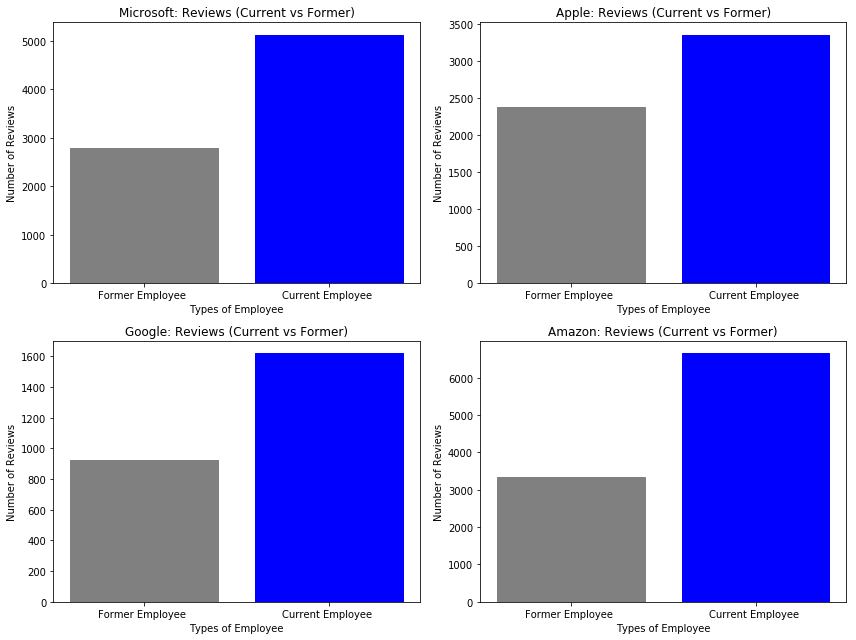

In [189]:

fig, axs = plt.subplots(2,2, figsize=(12, 9), facecolor='w', edgecolor='k')
companies = ['microsoft', 'apple', 'google', 'amazon']
axs = axs.ravel()


for i, company in enumerate(companies):
    current_employee_count = reviews_pd_df.loc[reviews_pd_df['company'] == company]['job_title'].str.split('-', expand=True)[0].value_counts().sort_values(ascending=True)
    employee_labels = current_employee_count.index.tolist()
    employee_index = np.arange(len(employee_labels))
        
    bars = axs[i].bar(employee_index, current_employee_count, tick_label=employee_labels)
    bars[0].set_color('gray')
    bars[1].set_color('b')
    _ = axs[i].set_xlabel('Types of Employee')
    _ = axs[i].set_ylabel('Number of Reviews')
    _ = axs[i].set_title('{}: Reviews (Current vs Former)'.format(company.title()))
    
fig.tight_layout()

### Plot the distributions of reviews for each company (current and former employees) and their overall ratings
- Hint: A Seaborn factorplot will work nicely here
    - https://kite.com/python/docs/seaborn.factorplot

# Lessons Learned
- Please feel free to let us know anything you want in this section about the test, what you learned, liked, didn't like, etc

It was a great experience working on this homework assignment I really enjoyed working on it, Due to time constraint as I have to complete it today EOD I was not able to work on vizualization as I have mostly done viz in R, so it will take little time for me to understand and apply those techniques and for Q.4 in Pyspark Implementation I created my functions correclty, still its not working. Please have a look at that question, rest all was fine